IN THIS NOTEBOOK we  TRY A  VISUAL APPROACH OF HOW THE FINE-TUNING AFECTS THE EMBEDDINGS.

In [ ]:
from sentence_transformers import SentenceTransformer, models
from sentence_transformers.training_args import BatchSamplers
import pandas as pd
from datasets import load_dataset, concatenate_datasets
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
import torch
torch.set_float32_matmul_precision('high')

Mounted at /content/drive


In [ ]:
df_unseen_test = pd.read_csv('/content/drive/Shareddrives/Master_Thesis/Data/unseen_test.csv')
df_train = pd.read_csv('/content/drive/Shareddrives/Master_Thesis/Data/train.csv')
df_test = pd.read_csv('/content/drive/Shareddrives/Master_Thesis/Data/test.csv')

print(len(df_unseen_test))
print(len(df_test))
print(len(df_train))
t=len(df_unseen_test)+len(df_test)+len(df_train)
print(t )


210
8668
79897
88775


In [ ]:
df_train.head()

,id,paper id,title,categories,type,content,question
0,130,2501.00784,cloitre's self-generating sequence,"['math.co', 'cs.dm', 'cs.fl', 'math.nt']",theorems,Let $g_n$ be the number of $1$'s in the sequen...,What is the limit of the proportion of 1's in ...
1,265,2501.00809,initial ideals of weighted forms and the genus...,"['math.ac', 'math.ag']",theorems,\label{ThmConjAreTrue}\nConjectures \ref{Conj1...,Does the statement of \textbf{ThmConjAreTrue} ...
2,266,2501.00809,initial ideals of weighted forms and the genus...,"['math.ac', 'math.ag']",propositions,}\n\newcommand{\ep}{,\\emph{Is the statement \emph{If $X$ is a comp...
3,267,2501.00809,initial ideals of weighted forms and the genus...,"['math.ac', 'math.ag']",definitions,}\n\newcommand{\ed}{,Is the statement $\ed{True}$?
4,313,2501.00845,spectral spaces of normal subgroups,"['math.gr', 'math.gn']",theorems,\label{mth}\nLet $G$ be a group having a maxim...,Does the set $\mathcal{N}^+(G)$ of proper norm...


Select 4 papers from different categories, that has more than 10 papers each.


In [ ]:
import pandas as pd
import random
counts = df_train['paper id'].value_counts()


eligible_papers = counts[counts >= 10].index.tolist()

#  Sample 4 papers at random
random.seed(41)
selected_papers = random.sample(eligible_papers, 4)

df_subset = df_train[df_train['paper id'].isin(selected_papers)]

print("Selected papers:", selected_papers)
print(df_subset.shape, "rows total")


Selected papers: [2501.15444, 2501.01228, 2501.05638, 2502.15517]
(91, 7) rows total


**SELECTED PAPERS: [2501.15444, 2501.01228, 2501.05638, 2502.15517]**

Categories:


*   2501.15444	['math.co']
*   2501.01228	['math.oc']
*   2502.15517	['math.ag', 'math.rt']
*   2501.05638	['cs.cc', 'cs.dm', 'cs.ds', 'math.co']




In [ ]:
df_final = df_subset[['paper id','categories','content']]
df_final

,paper id,categories,content
1210,2501.01228,['math.oc'],\label{th:symmetry}\nIf $\Om^*$ is a solution ...
1487,2501.01228,['math.oc'],Let $\F$ be a class of subsets of $\R^2$ and $...
2817,2502.15517,"['math.ag', 'math.rt']",[{\cite[Lemma~3]{FRKronecker}}] \label{A1tilde...
5646,2501.15444,['math.co'],[{see also~\cite[Theorem~4.3]{DGS}}]\label{lem...
5775,2501.15444,['math.co'],"\label{lem:ls}\r\nLet $W,C_i$ be the same as i..."
...,...,...,...
77055,2502.15517,"['math.ag', 'math.rt']",\label{Tor(Pbb1) = Reg(C) stacky}\n\tThe funct...
77449,2502.15517,"['math.ag', 'math.rt']",\label{KünnethIsoIfAffinePaving}\n\tIf~$\mathf...
79282,2501.05638,"['cs.cc', 'cs.dm', 'cs.ds', 'math.co']",\label{lem:matching-edges-are-clean}\n Let $(...
79604,2501.15444,['math.co'],[{\cite[Corollary 10]{BKR}}]\label{prop:f}\r\n...


In [ ]:
# import model NO FT
from sentence_transformers import SentenceTransformer, models

repo_id = "Master-thesis-NAP/ModernBert-DAPT-math"


word_model = models.Transformer(repo_id )

pooling = models.Pooling(
    word_model.get_word_embedding_dimension(),
    pooling_mode_mean_tokens=True,
)
model = SentenceTransformer(modules=[word_model, pooling])

config.json:   0%|          | 0.00/1.22k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/599M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/20.8k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.58M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/694 [00:00<?, ?B/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

W0531 13:28:12.318000 1418 torch/_inductor/utils.py:1137] [1/0] Not enough SMs to use max_autotune_gemm mode


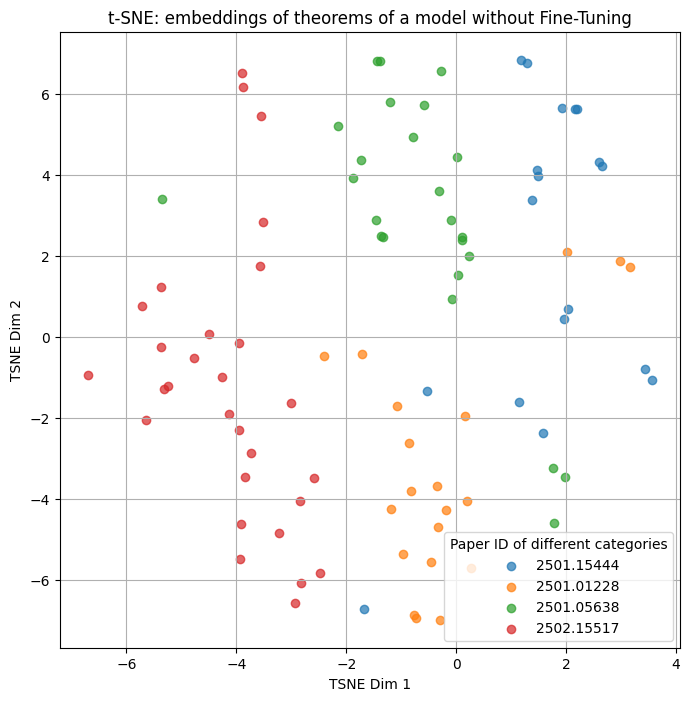

In [ ]:
#Plot the embeddings using T-sne
import random
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

texts = df_final['content'].tolist()
labels = df_final['paper id'].tolist()
embeddings = model.encode(
    texts,
    convert_to_numpy=True,
    show_progress_bar=True
)

tsne_proj = TSNE(
    n_components=2,
    perplexity=30,
    init='random',
    random_state=42
).fit_transform(embeddings)

plt.figure(figsize=(8, 8))
for paper in selected_papers:
    idxs = [i for i, p in enumerate(labels) if p == paper]
    plt.scatter(
        tsne_proj[idxs, 0],
        tsne_proj[idxs, 1],
        label=str(paper),
        alpha=0.7
    )

plt.legend(title="Paper ID of different categories")
plt.title("t-SNE: embeddings of theorems of a model without Fine-Tuning")
plt.xlabel("TSNE Dim 1")
plt.ylabel("TSNE Dim 2")
plt.grid(True)
plt.show()

WITH FINE TUNING:

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/205 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/46.2k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/54.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/596M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/21.0k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.58M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/694 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

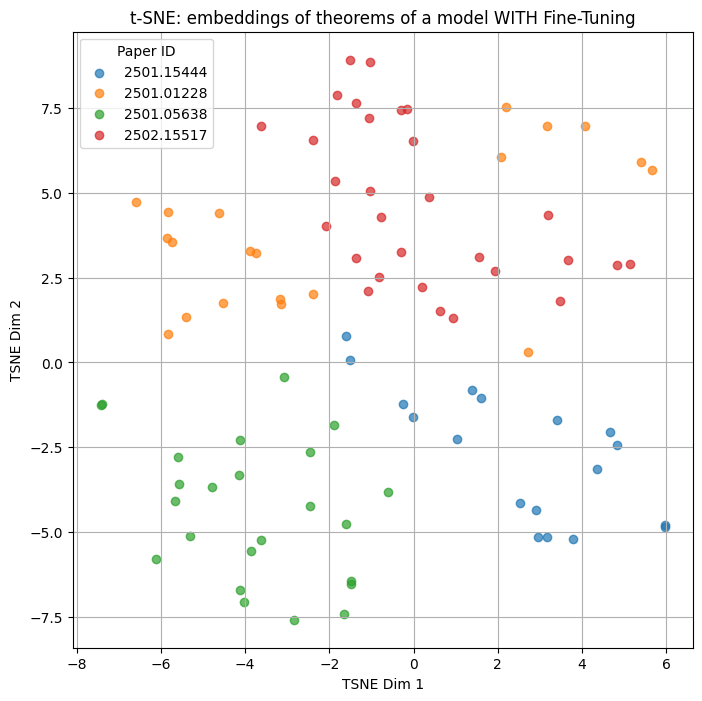

In [ ]:
model2 = SentenceTransformer("Master-thesis-NAP/ModernBERT-DAPT-Embed-DAPT-Math")

embeddings = model2.encode(
    texts,
    convert_to_numpy=True,
    show_progress_bar=True
)


tsne_proj = TSNE(
    n_components=2,
    perplexity=30,
    init='random',
    random_state=42
).fit_transform(embeddings)


plt.figure(figsize=(8, 8))
for paper in selected_papers:
    idxs = [i for i, p in enumerate(labels) if p == paper]
    plt.scatter(
        tsne_proj[idxs, 0],
        tsne_proj[idxs, 1],
        label=str(paper),
        alpha=0.7
    )

plt.legend(title="Paper ID")
plt.title("t-SNE: embeddings of theorems of a model WITH Fine-Tuning")
plt.xlabel("TSNE Dim 1")
plt.ylabel("TSNE Dim 2")
plt.grid(True)
plt.show()